# Algorithm
choose any k examples as centroids, examples closest will be attributed to centroid.

compute new centroid, and ressign examples to new centroid.

Itirate until centroids dont change

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist



# Import data

In [7]:
path = "C:\\CSE\\MachineLearning\\Clustering\\Clustering_Data.csv"
data = pd.read_csv(path)
data = data.drop(columns=["Unnamed: 0"], errors="ignore")
data

,Alcohol,Malic_Acid,Ash,Ash_Alcanity,Magnesium,Total_Phenols,Flavanoids,Nonflavanoid_Phenols,Proanthocyanins,Color_Intensity,Hue,OD280,Proline,Customer_Segment
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065,1
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050,1
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185,1
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480,1
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
173,13.71,5.65,2.45,20.5,95,1.68,0.61,0.52,1.06,7.70,0.64,1.74,740,3
174,13.40,3.91,2.48,23.0,102,1.80,0.75,0.43,1.41,7.30,0.70,1.56,750,3
175,13.27,4.28,2.26,20.0,120,1.59,0.69,0.43,1.35,10.20,0.59,1.56,835,3
176,13.17,2.59,2.37,20.0,120,1.65,0.68,0.53,1.46,9.30,0.60,1.62,840,3


# Scale down using Z score scaling

In [8]:

data_array  = np.array(data) 
k = data_array.shape[1]
for i in range(k):
    data_array[:,i] = (data_array[:,i] - np.mean(data_array[:,i]))/np.std(data_array[:,i])


choose cluster first at random from data and keep updating until no change in centroid

In [46]:

def Find_centroid(cluster):# returns a 1d array with 2 elements (x,y)
    return np.mean(cluster, axis=0)  # Compute mean along the columns (x and y)


def assign_to_nearest_centroid(point,centroids):
    k = len(centroids)
    cluster = np.empty(0)
    n = point.shape[0]
    for i in range(n):
        distance = np.empty(k)
        for j in range(k):
            distance[j] = np.linalg.norm(centroids[j]-point[i]) # find distances for each point wrt csntroids  
        cluster = np.append(cluster,np.argmin(distance)) # after all k distances are found the min is found and index of min distance is appended into cluster
    return cluster

def update(data_array,centroids,clusters,k):
    '''Algorithm :
    1. find new new centroids wrt to current clusters
    2. Update clusters wrt new centroids
    3. return change in centroids           '''
    change_in_centroids = np.empty(0)
    centroids_new = np.zeros((k, centroids.shape[1])) # sets up a empty array with columns = no of features
    
    # step 1 - cluster form (index of centroid are elements corresponding to their position in data_array
    for i in range(k):
        indices = [index for index, value in enumerate(clusters) if value == i] # gives indices elements in same cluster
        centroids_new[i] = Find_centroid(data_array[indices]) 
        
    # step 2 - Update clusters
    cluster_new = assign_to_nearest_centroid(data_array,centroids_new)
   
    
    # Step 3 - return change in centroids
    for i in range(k):
        change_in_centroids = np.append(change_in_centroids,np.linalg.norm(centroids_new[i] - centroids[i]))
    return change_in_centroids,cluster_new,centroids_new # returns distance bw centroids

    
def within_cluster_ss(data_array,clusters,centroids,k):
    wcss = 0
    for i in range(k):
        indices = [index for index, value in enumerate(clusters) if value == i] # gives indices elements in same cluster
        for j in range(len(indices)):
            wcss = wcss + (np.linalg.norm(centroids[i] - data_array[indices[j]] ))**2
    return(wcss)

def Dunn_index(data_array,clusters,centroids,k):
    '''ratio of min distance bw Clusters and max distance in between cluster'''
    inter_cluster_distances = cdist(centroids, centroids)
    np.fill_diagonal(inter_cluster_distances, np.inf)
    inter_cluster_dist_min = np.min(inter_cluster_distances)

    max_dist_intra_cluster = 0
    for i in range(k):
        indices = np.where(clusters == i)
        intra_cluster_distance = cdist(data_array[indices],data_array[indices])
        max_intra_cluster_dist = np.max(intra_cluster_distance)
        max_dist_intra_cluster = max(max_dist_intra_cluster, max_intra_cluster_dist) # update global max
    return inter_cluster_dist_min/max_dist_intra_cluster

# Initialize 

In [47]:
a = data_array.shape[1]# max k being = no of features
n = data_array.shape[0] # number of data points to choose random form
wcss_his = np.array([])
dunn_index_his = np.array([])


# Itirate accross multiple values of K

In [48]:
for i in range(2,a+1):
    #initialize
    wcss = 0
    k = i
    centroids = np.empty((0, data_array.shape[1])) # sets up a empty array with columns = no of features
    random_numbers = random.sample(range(1, n), k) # get initial random centroids
    centroids = np.vstack([centroids, data_array[random_numbers]])
    
    while True:
        clusters = assign_to_nearest_centroid(data_array,centroids)
        dist,cluster,centroids = update(data_array,centroids,clusters,k)
        
        
        
        if np.all(dist < 1e-6):  # Arbitrary small threshold for convergence
            break
    dunn = Dunn_index(data_array,clusters,centroids,k)
    dunn_index_his = np.append(dunn_index_his,dunn)
    wcss = within_cluster_ss(data_array,clusters,centroids,k)    
    wcss_his = np.append(wcss_his,wcss)

    

# WCss vs K graph

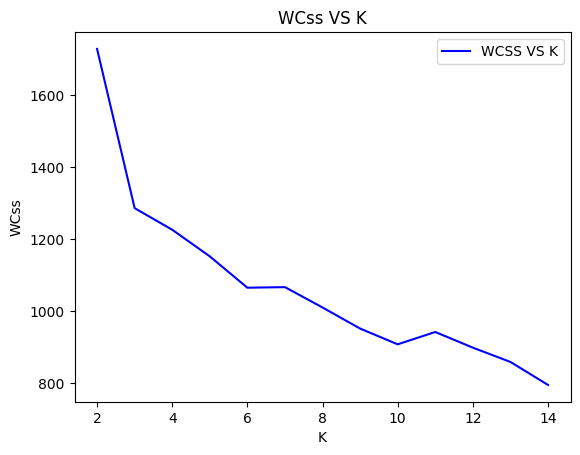

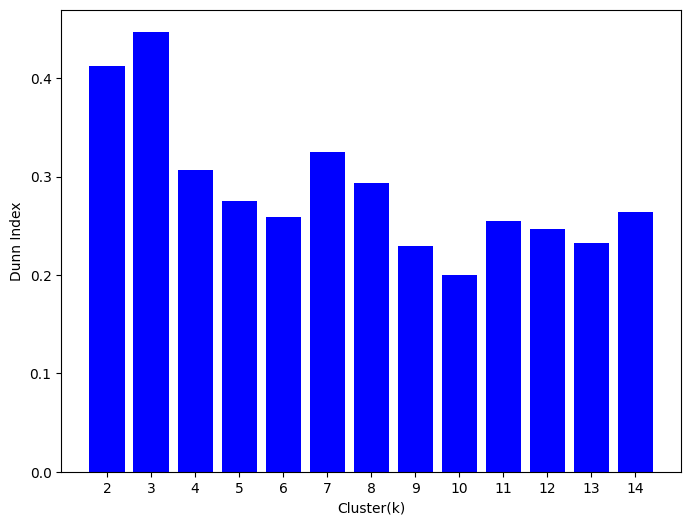

In [56]:
plt.plot(range(2, 2 + len(wcss_his)), wcss_his, color='blue', label='WCSS VS K')
plt.title('WCss VS K')
plt.xlabel('K')
plt.ylabel('WCss')
plt.legend()
plt.show()

plt.figure(figsize=(8, 6))
plt.bar(range(2, 2 + len(dunn_index_his)), dunn_index_his, color='blue')
plt.xlabel('Cluster(k)')
plt.ylabel('Dunn Index')
plt.xticks(range(2, 2 + len(dunn_index_his)))  # Set x-ticks to the cluster indices
plt.show()



# Optimum K value
After observing the Wcss vs K graph, I have chosen the value of K to be 3, as I git the elobw at K = 3 and around consistantly.

Also looking at dunn's index, whose max value gives the optimum no of clusters
## Execute K means Clustering for K = 3

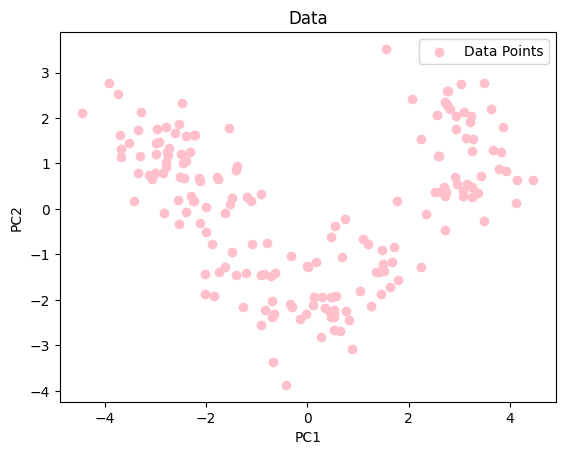

In [13]:
pca = PCA(n_components=2)
data_pca = pca.fit_transform(data_array)
plt.scatter(data_pca[:,0],data_pca[:,1],alpha= 1,color = 'pink', label = 'Data Points')
plt.title('Data')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.legend()
plt.show()


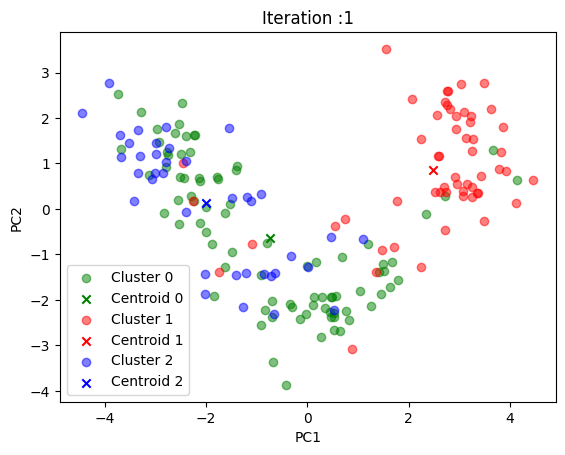

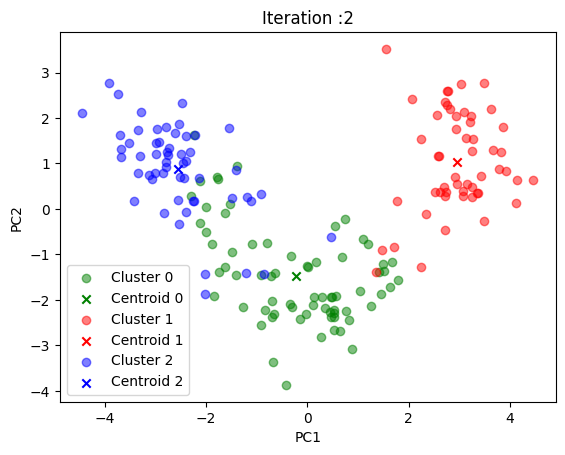

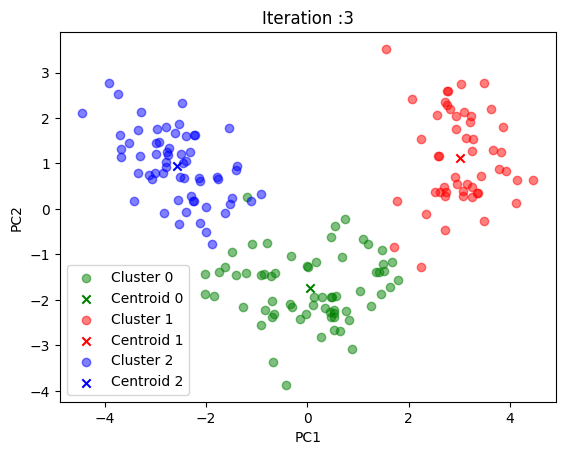

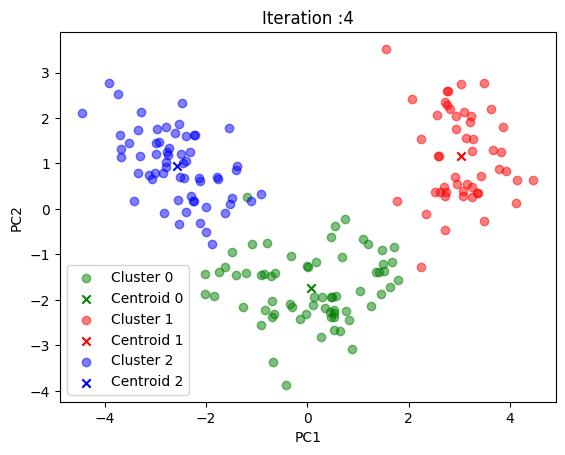

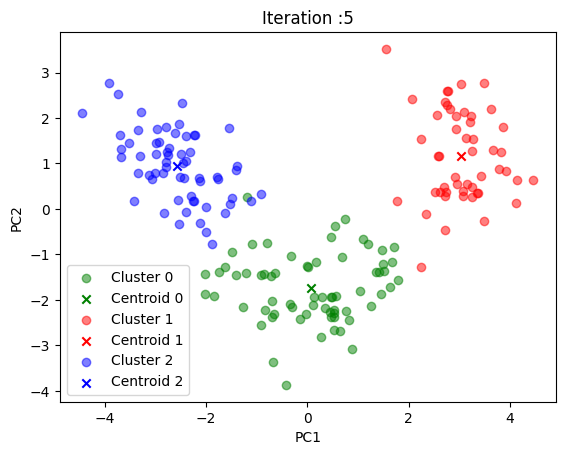

In [59]:
wcss = 0
k =3

centroids = np.empty((0, data_array.shape[1])) # sets up a empty array with columns = no of features
random_numbers = random.sample(range(1, n), k) # get initial random centroids
centroids = np.vstack([centroids, data_array[random_numbers]])
itr = 0
while True:
    itr = itr+1
    clusters = assign_to_nearest_centroid(data_array,centroids)
    
    color = ['green', 'red', 'blue','orange']
    for i in range(k):
        centroid = np.zeros(2)
        indices = [index for index, value in enumerate(clusters) if value == i] # gives indices elements in same cluster
        centroid = Find_centroid(data_pca[indices])             # find centroid in new plane
        plt.scatter(data_pca[indices,0],data_pca[indices,1],alpha= 0.5,color = color[i], label = f'Cluster {i}')
        plt.scatter(centroid[0],centroid[1], marker='x',color = color[i],label = f'Centroid {i}' )
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title(f'Iteration :{itr}')
    plt.legend()
    plt.show()
    dist,cluster,centroids = update(data_array,centroids,clusters,k)
        
    if np.all(dist < 1e-6):  # Arbitrary small threshold for convergence
        break
